# Fitting a Line Using MCMC
By Griffin Hosseinzadeh (2019 April 17)  
Updated by Charlotte Mason (2020 August 28)  
Updated by Griffin Hosseinzadeh (2025 April 30)

In [37]:
import numpy as np
import matplotlib.pyplot as plt

import emcee
import corner

## Generate Some Fake Data
Choose a slope $m$, intercept $b$, and scatter $\sigma$, and generate $N$ random points using the `np.random` module. Plot the results to see what your data look like. Our goal is to recover the parameters defined here. (Hint: this section is identical to the previous notebook.)

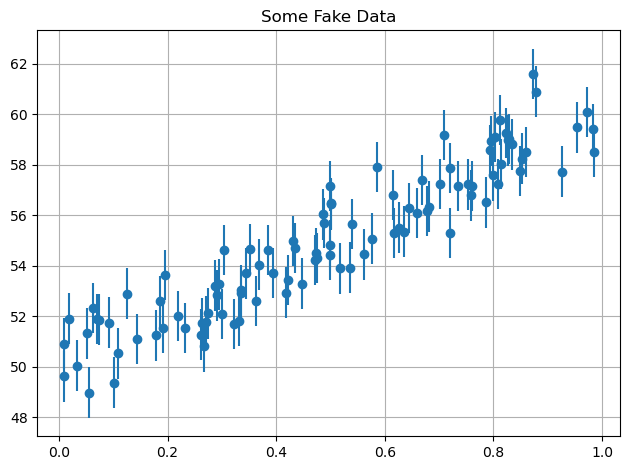

In [38]:
# complete
# complete
# complete
# complete

N = 100  # number of points
m = 10.  # slope
b = 50.  # intercept
sigma = 1.  # scatter

rng = np.random.default_rng()
x = rng.random(size=N)  # complete with random values between 0 and 1
y = ((m*x) + b) + rng.normal(loc=0, scale=sigma, size=N) # equation for a line PLUS random values from a Gaussian centered at 0 with standard deviation `sigma`
dy = np.full(N, sigma) # array of error bars for all the data (all `sigma`)


# plot your generated data with error bars
plt.errorbar(x, y, yerr=dy, fmt='o')
plt.title('Some Fake Data')
plt.grid(True)
plt.tight_layout()
plt.show()



## Write Down the Posterior
Define functions that return the prior, the likelihood, and the posterior given a parameter vector `theta = [m, b]`. For computational accuracy (and convenience), we actually want to do this in log space. You can either use `np.log` (natural log) or `np.log10` (base-10 log). Regardless of the shape of your prior, it's good practice to limit the values of $m$ and $b$ to some reasonable range. (Hint: this section is identical to the previous notebook.)

In [39]:
# complete
# complete
# complete
# complete

def log_prior(theta): 
    m, b = theta
    if 0.0 < m < 100.0 and 0.0 < b < 100.0:
        return 0.0
    return -np.inf

def log_likelihood(theta, x, y, dy):
    m, b = theta
    model = m * x + b
    chi2 = ((y - model) / dy)**2
    logL = -0.5 * np.sum(np.log(2 * np.pi * dy**2) + chi2)
    return logL

def log_posterior(theta, x, y, dy):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, dy)
    

## Set Up the Ensemble Sampler
This time we will use the `emcee` package that you imported above to sample the posterior probability distribution. Everything you need is contained within the `emcee.EnsembleSampler` class. Initialize this with 100 walkers and the `log_posterior` function you defined above. Don't forget that `log_posterior` takes additional arguments `x`, `y`, and `dy`. (Hint: check the documentation for `EnsembleSampler` for how to deal with this.)

Note, we will initialise the sampler in #1.5

In [40]:
n_walkers = 100
n_params = 2
args = (x, y, dy)

## Setup random initial guesses for the starting positions

You'll need to give initial guesses for each walker, which you can draw randomly from the prior. 

In [41]:
m_random = np.random.uniform(0, 100, n_walkers)
b_random = np.random.uniform(0, 100, n_walkers)
initial_guesses = np.column_stack((m_random, b_random))

## Initialize and run!

Initialize the `EnsembleSampler` object and then run it with the `run_mcmc` method. For now, 10000 steps is more than enough, and should run in less than a minute on your laptop. If this command takes too long, ask for help.

In [46]:
# initialize the sampler
sampler = emcee.EnsembleSampler(n_walkers, n_params, log_posterior, args=args)

# run!
sampler.run_mcmc(initial_guesses, 1000)

State([[10.20979215 49.69068934]
 [ 9.99131648 50.04242797]
 [10.18513976 49.9841795 ]
 [ 9.85318173 50.02704916]
 [10.05708719 50.03498669]
 [ 9.92309406 50.05431174]
 [ 9.63763587 50.39076606]
 [ 9.58728259 50.17958275]
 [10.47581033 49.82914278]
 [10.86151233 49.5496421 ]
 [10.73739564 49.5796772 ]
 [ 9.73255334 50.20451734]
 [ 9.86301544 49.9523525 ]
 [ 9.63709377 50.2190964 ]
 [10.38086479 49.73504193]
 [ 9.95377154 49.97819613]
 [ 9.90574051 49.90663018]
 [10.09413763 50.02911622]
 [ 9.73009067 50.39527817]
 [10.05879008 50.03571053]
 [10.67681195 49.7765143 ]
 [10.36287281 49.79415322]
 [ 9.14650247 50.28061062]
 [ 9.85061406 50.14948732]
 [10.42533999 49.8614685 ]
 [ 9.47179801 50.09923606]
 [10.16970359 50.12221392]
 [ 9.87908956 50.28479077]
 [ 9.49575588 50.35897197]
 [10.08561848 50.01456556]
 [ 9.85774509 50.0138406 ]
 [10.65074674 49.58614723]
 [10.05109321 49.91210931]
 [10.39466972 49.47124835]
 [ 9.98958773 50.07248413]
 [10.17522021 49.95954106]
 [10.20671775 49.98461

## Plot the Results
First make a plot of the walker positions (value of each parameter) at each step. Write a function to do this, since you'll be using it a lot.

(100, 1000, 2)


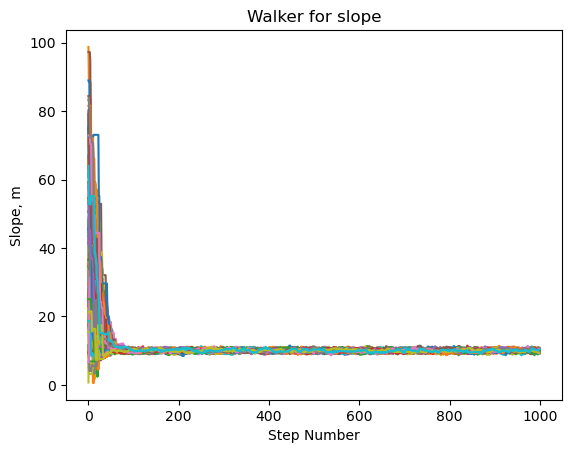

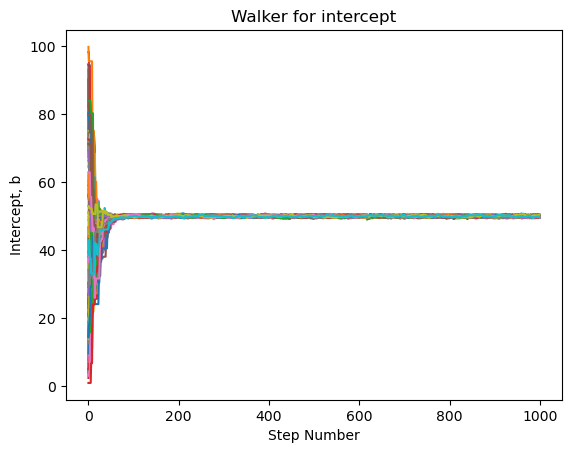

In [47]:
print(sampler.chain.shape)  # check that this has dimensions (n_walkers, n_steps, n_params)

def chain_plots(chain, **kwargs):
    """
    Plot the histories for each walker in sampler.chain
    
    Parameters
    ----------
    chain: ndarray
        3D array given by sampler.flatchain, with shape (n_walkers, n_steps, n_params)
    kwargs: `.Line2D` properties, optional
        All keyword arguments are passed to `pyplot.plot`
    """
    
    n_walkers, n_steps, n_params = chain.shape
    
    plt.figure()
    plt.plot(chain[:, :, 0].T, **kwargs)
    plt.xlabel('Step Number')
    plt.ylabel('Slope, m')
    plt.title('Walker for slope')

    plt.figure()
    plt.plot(chain[:, :, 1].T, **kwargs)
    plt.xlabel('Step Number')
    plt.ylabel('Intercept, b')
    plt.title('Walker for intercept')
    
chain_plots(sampler.chain)

Each one of those colored lines is a walker. They started out at your initial guesses. What do you immediately notice?

Try making more useful plots by zooming in on the relevant parts. Hint: you can adjust line opacity in matplotlib with the `alpha` parameter.

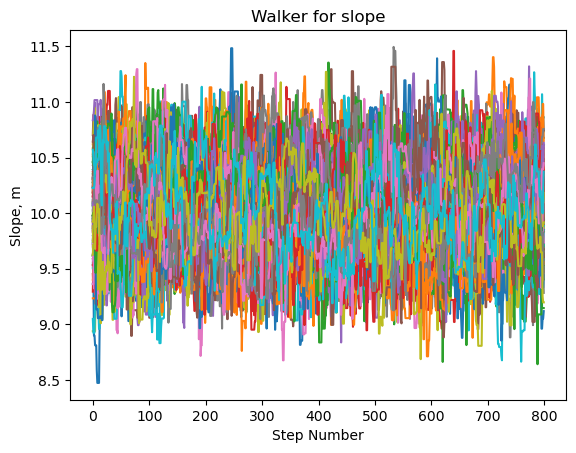

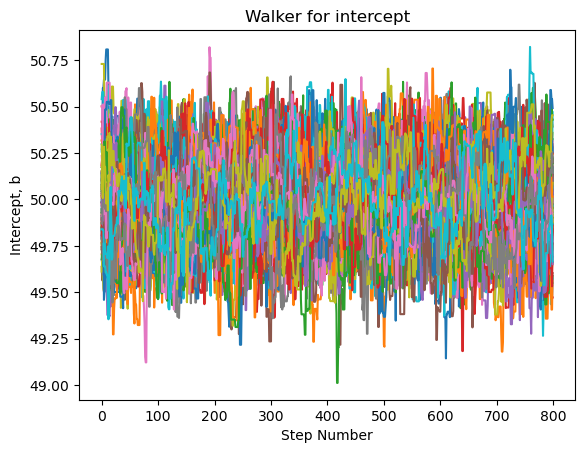

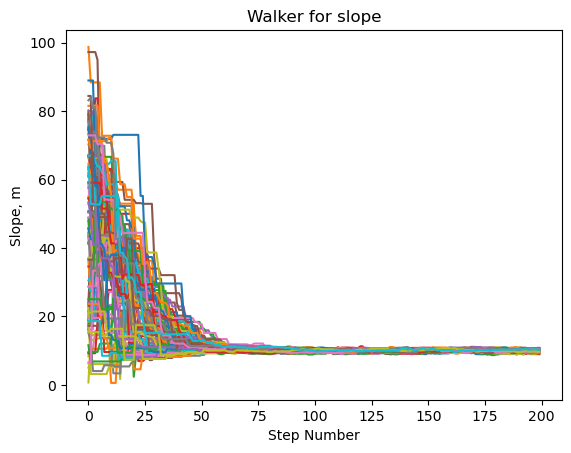

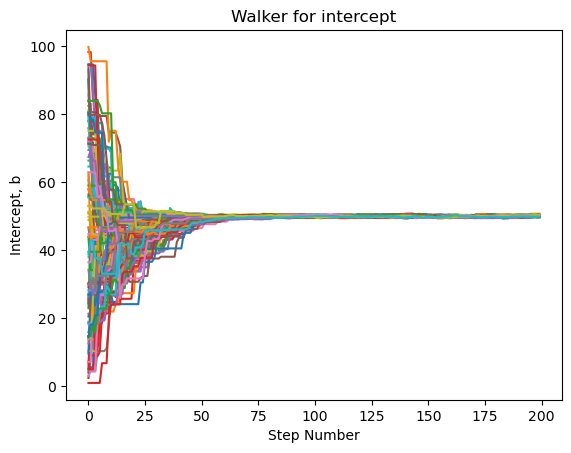

In [57]:
n_burn = 200
chain_plots(sampler.chain[:, n_burn:, :])  # for slope
chain_plots(sampler.chain[:, :n_burn, :])  # for intercept

Are your chains converged? How many steps did it take for this to happen? This is called the "burn-in" period. **From now on, only use the steps after the burn-in period.**

Now make a scatter plot of the two parameters, one point for each walker-step. Hint: `sampler.flatchain`.

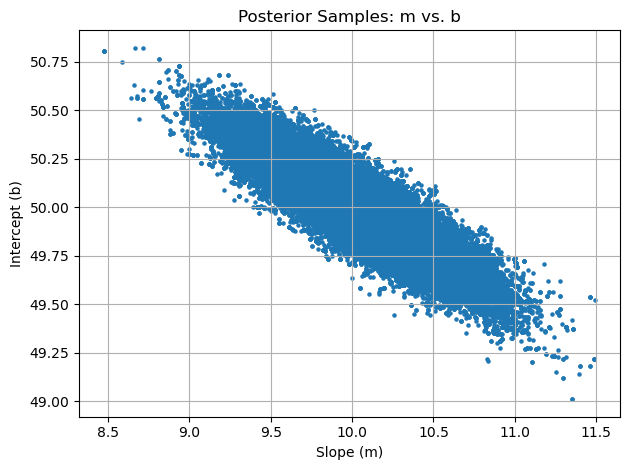

In [59]:
# complete
flat_samples = sampler.get_chain(discard=n_burn, flat=True)

# plot
plt.figure()
plt.scatter(flat_samples[:, 0], flat_samples[:, 1], s=5)
plt.xlabel("Slope (m)")
plt.ylabel("Intercept (b)")
plt.title("Posterior Samples: m vs. b")
plt.grid(True)
plt.tight_layout()
plt.show()


How does this compare to the distribution you had in the previous notebook (assuming you used the same parameters)?

Now let's marginalize over each parameter. Given that we have walkers that are distributed according to the 2D posterior, think about how to calculate the marginalized posterior for each parameter.

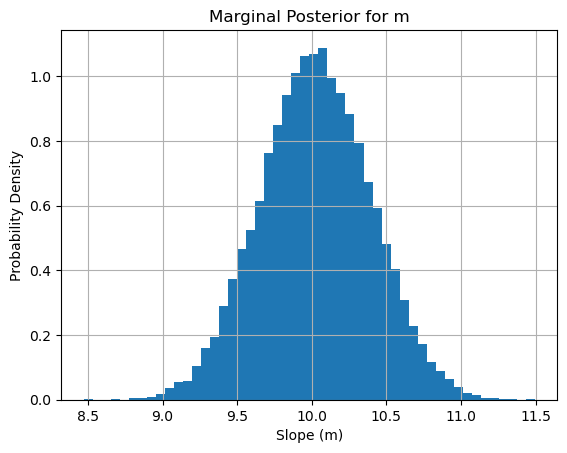

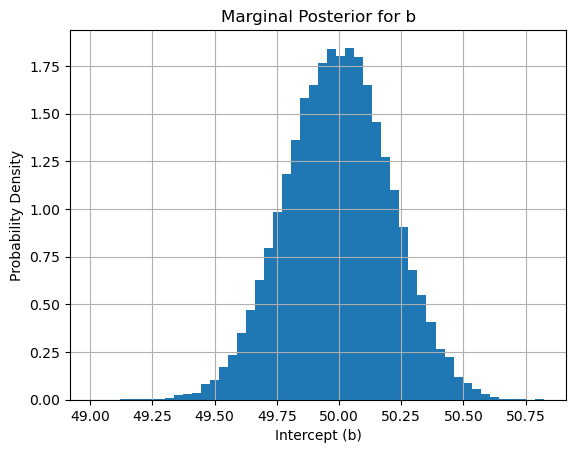

In [60]:
# For slope
plt.figure()
plt.hist(flat_samples[:, 0], bins=50, density=True)
plt.xlabel("Slope (m)")
plt.ylabel("Probability Density")
plt.title("Marginal Posterior for m")
plt.grid(True)


# For intercept
plt.figure()
plt.hist(flat_samples[:, 1], bins=50, density=True)
plt.xlabel("Intercept (b)")
plt.ylabel("Probability Density")
plt.title("Marginal Posterior for b")
plt.grid(True)

plt.show()

Calculate the medians and the 68% ($1\sigma$) confidence intervals for each parameter. Check your answers against the centers and widths of the distributions you just plotted above. Do they look about right?

In [61]:
m_lo, m_med, m_hi = np.percentile(flat_samples[:, 0], [16, 50, 84])
b_lo, b_med, b_hi = np.percentile(flat_samples[:, 1], [16, 50, 84])

# Compute ±1 intervals
dm_lo = m_med - m_lo
dm_hi = m_hi - m_med
db_lo = b_med - b_lo
db_hi = b_hi - b_med

# complete
print(f'$m = {m_med:.2f}_{{{dm_lo:+.2f}}}^{{{dm_hi:+.2f}}}$')

# complete
print(f'$b = {b_med:.2f}_{{{db_lo:+.2f}}}^{{{db_hi:+.2f}}}$')

$m = 10.03_{+0.37}^{+0.37}$
$b = 50.00_{+0.21}^{+0.21}$


There's an easy way to generate all these plots and summary statistics: `corner.corner`! Produce a corner plot with the true parameters labeled and the best-fit values (with error bars) printed on the plot. How close did we get to the parameters we used to generate the data?

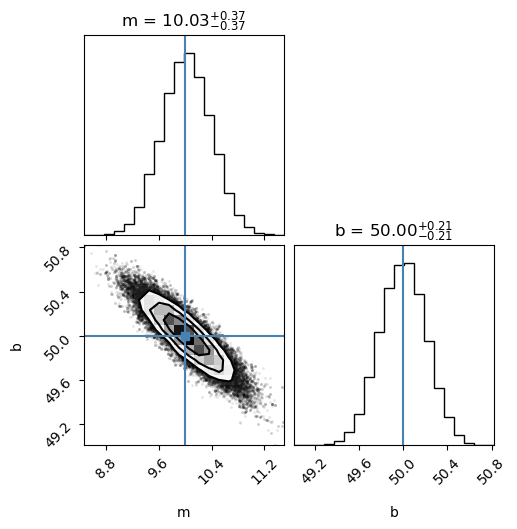

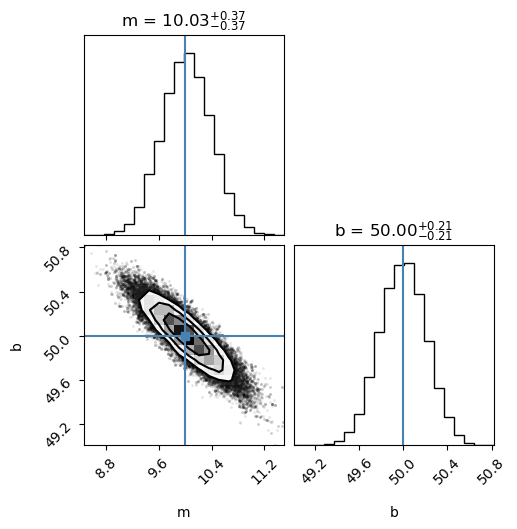

In [62]:
corner.corner(
    flat_samples,
    labels=["m", "b"],
    truths=[m_true, b_true],
    show_titles=True,  
)

## Take-Away Message
MCMC is a much more efficient way to sample the probability distribution because the walkers mostly stay in the highest-probability region. Plus it essentially gives you the marginalized posteriors for free, because the density of walkers matches the probability density.

## Other Things to Try
- Add a parameter for the intrinsic scatter and redo the MCMC fit.
- Try implementing Metropolis-Hastings algorithm yourself and see if you can get the same results as `emcee`.